In [34]:
import os
import random

import torch
import torch.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import numpy as np

%matplotlib inline

In [35]:
CONTEXT_SIZE = 3
EMBEDDING_DIM = 2
NUM_CHARACTERS = 27

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = torch.Generator().manual_seed(42)

In [36]:
with open("../names.txt", "r") as f:
    names = f.read().splitlines()

In [37]:
characters = sorted(set(list(''.join(names))))
stoi = {c: i+1 for i, c in enumerate(characters)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [117]:
def build_dataset(words, context_size=CONTEXT_SIZE, shuffle=False, seed=None):
    X, Y  = [], []

    if shuffle:
        random.seed(seed)
        random.shuffle(words)

    for w in words:
        context = [0] * context_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)

            # print(f"{''.join(map(lambda x: itos[x], context))} ---> {itos[ix]}")

            context = context[1:] + [ix]

    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)

    print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

    return X, Y

def split_dataset(X, Y, train_ratio=0.8, val_ratio=0.1):


    n1 = int(train_ratio * X.shape[0])
    n2 = int((train_ratio + val_ratio) * X.shape[0])

    X_t, Y_t = X[:n1], Y[:n1]
    X_v, Y_v = X[n1:n2], Y[n1:n2]
    X_test, Y_test = X[n2:], Y[n2:]

    print(f"X_t.shape: {X_t.shape}, Y_t.shape: {Y_t.shape}")
    print(f"X_v.shape: {X_v.shape}, Y_v.shape: {Y_v.shape}")
    print(f"X_test.shape: {X_test.shape}, Y_test.shape: {Y_test.shape}")
    assert(X.shape[0] == X_t.shape[0] + X_v.shape[0] + X_test.shape[0])

    return X_t, Y_t, X_v, Y_v, X_test, Y_test


class MLP(nn.Module):
    def __init__(
        self,
        num_characters=NUM_CHARACTERS,
        embedding_dim=EMBEDDING_DIM,
        context_size=CONTEXT_SIZE,
        hidden_dim=100,
        generator=None,
    ):
        super().__init__()

        self.model = nn.Sequential(
            nn.Embedding(num_characters, embedding_dim),
            nn.Flatten(),
            nn.Linear(context_size * embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 100),
            nn.ReLU(),
            nn.Linear(100, num_characters)
        )


        self.apply(self.__init_weights)

        print(f"Number of parameters: {self.get_num_parameters()}")

    def __init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.xavier_uniform_(module.weight)
            if module.padding_idx is not None:
                nn.init.zeros_(module.weight[module.weight.padding_idx])

    def get_num_parameters(self, trainable_only=True):
        return sum(p.numel() for p in self.parameters() if not trainable_only or p.requires_grad)

    def forward(self, x):
        logits = self.model(x)
        return logits


def train(
    mlp,
    X_tr,
    Y_tr,
    lr: float = 1e-3,
    epochs: int = 1000,
    batch_size=32,
    generator=None,
    device="cpu",
):
    mlp.train()
    optimizer = torch.optim.AdamW(mlp.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()


    X_tr = X_tr.to(device)
    Y_tr = Y_tr.to(device)
    train_losses = []
    for e in tqdm.tqdm(range(epochs), position=0, leave=True):
        mini_batch_idx = torch.randint(
            0, X_tr.shape[0], (batch_size,), generator=generator
        )
        X_batch = X_tr[mini_batch_idx]
        Y_batch = Y_tr[mini_batch_idx]

        logits = mlp(X_batch)
        loss = loss_fn(logits, Y_batch)
        train_losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    print(f"Finished training: Train Loss: {train_losses[-1]:.4f}")

    return train_losses


@torch.no_grad()
def eval_model(mlp, X, Y):
    loss_fn = nn.CrossEntropyLoss()
    mlp.eval()
    logits = mlp(X)
    loss = loss_fn(logits, Y).item()

    prob = logits.softmax(dim=1)
    Y_pred = prob.argmax(dim=1)
    acc = (Y_pred == Y).float().mean()
    
    return loss, acc

In [104]:
X, Y = build_dataset(names, shuffle=True, seed=None)
X = X.to(device)
Y = Y.to(device)
X_tr, Y_tr, X_v, Y_v, X_te, Y_te = split_dataset(
    X, Y, train_ratio=0.8, val_ratio=0.1
)

X.shape: torch.Size([228146, 3]), Y.shape: torch.Size([228146])
X_t.shape: torch.Size([182516, 3]), Y_t.shape: torch.Size([182516])
X_v.shape: torch.Size([22815, 3]), Y_v.shape: torch.Size([22815])
X_test.shape: torch.Size([22815, 3]), Y_test.shape: torch.Size([22815])


In [105]:
mlp = MLP(generator=generator, embedding_dim=32, hidden_dim=512).to(device)

Number of parameters: 104555


In [108]:
train_losses = train(
    mlp, X_tr, Y_tr, lr=5e-4, epochs=100_000, batch_size=64, device=device
)


100%|██████████| 100000/100000 [02:24<00:00, 693.65it/s]

Finished training: Train Loss: 1.8671


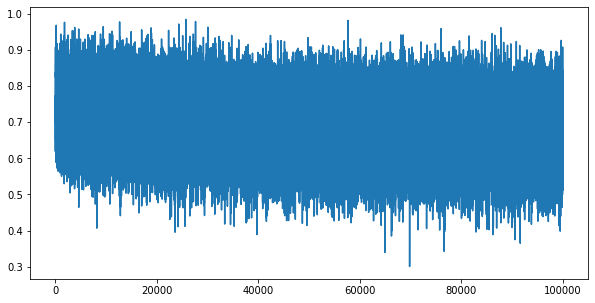

In [109]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(train_losses)), np.log(train_losses), label="Train Loss")


In [118]:
val_loss, val_acc = eval_model(mlp, X_v, Y_v)
print(f"Val Loss: {val_loss:.4f}")

test_loss, test_acc = eval_model(mlp, X_te, Y_te)
print(f"Test Loss: {test_loss:.4f}")

Val Loss: 2.1049
Test Loss: 2.0797


In [119]:
val_acc, test_acc

(tensor(0.3353, device='cuda:0'), tensor(0.3440, device='cuda:0'))

In [135]:
print(eval_model(mlp, X_tr, Y_tr))

(1.9715803861618042, tensor(0.3620, device='cuda:0'))


In [158]:
@torch.no_grad()
def generate(mlp, context_size, itos, device="cpu", generator=generator):
    context = [0] * context_size

    word = ""
    mlp.eval()
    mlp.to(device)
    while True:
        context_tensor = torch.unsqueeze(torch.tensor(context), dim=0).to(device)
        logits = mlp(context_tensor)
        prob = logits.softmax(dim=1)
        next_letter_idx = torch.multinomial(
            prob, num_samples=1, replacement=True, generator=generator
        ).item()
        context = context[1:] + [next_letter_idx]
        letter = itos[next_letter_idx]
        if letter == ".":
            break
        word += letter

    return word


In [159]:
for i in range(10):
    word = generate(
        mlp, context_size=CONTEXT_SIZE, itos=itos, device="cpu", generator=generator
    )
    print(word)


angstefanovan
mel
maka
valee
daris
ely
jazziah
nechazella
nashimso
kylah
